Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 3823, number of used features: 56
[LightGBM] [Info] Start training from score -0.103531
[LightGBM] [Info] Start training from score -2.319202
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits 

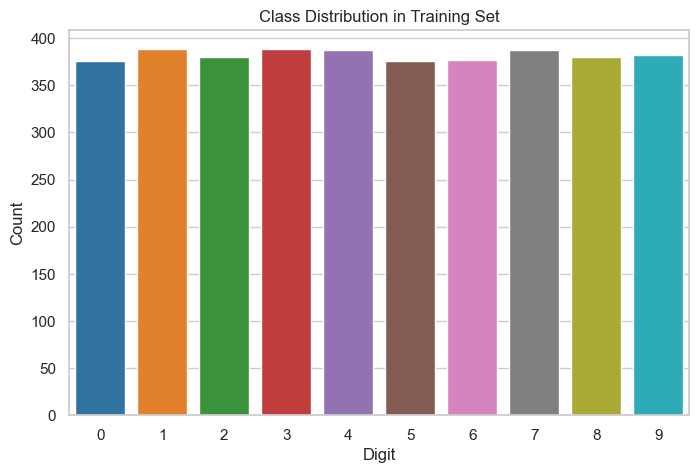

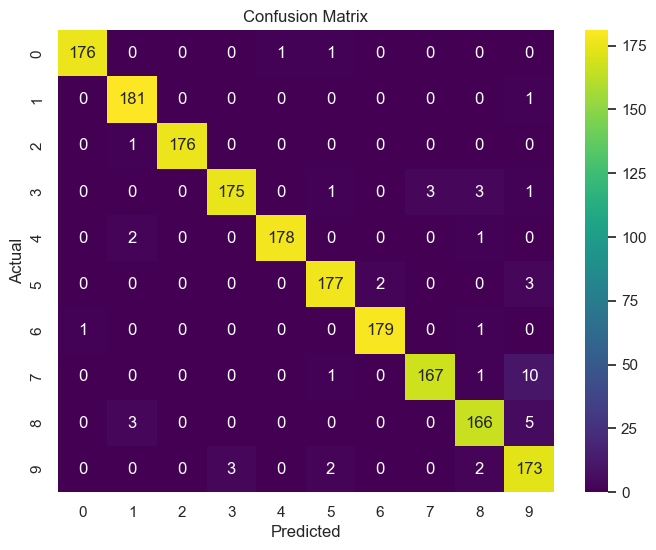

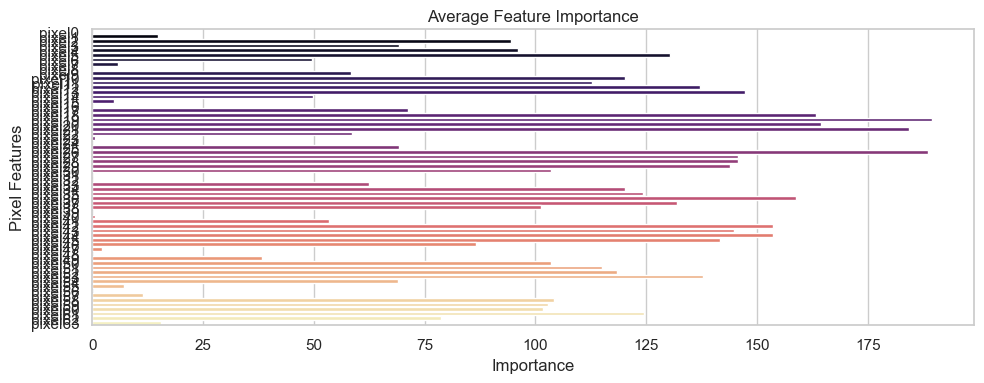

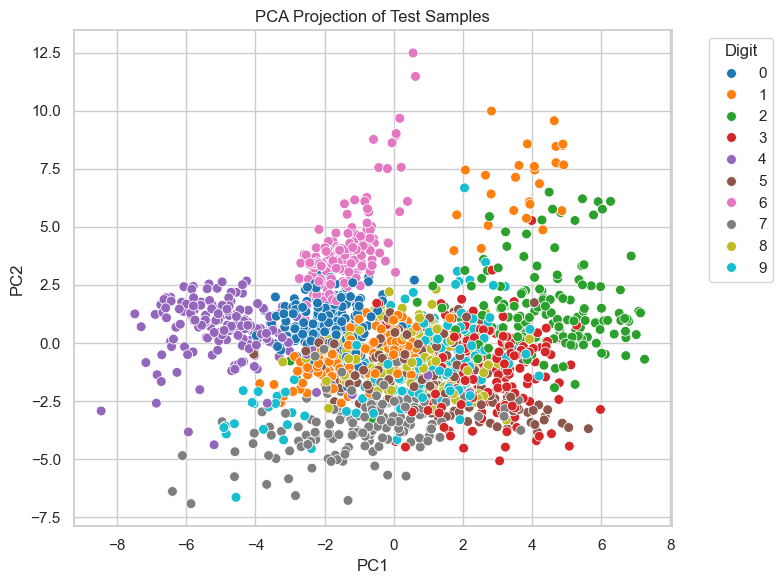

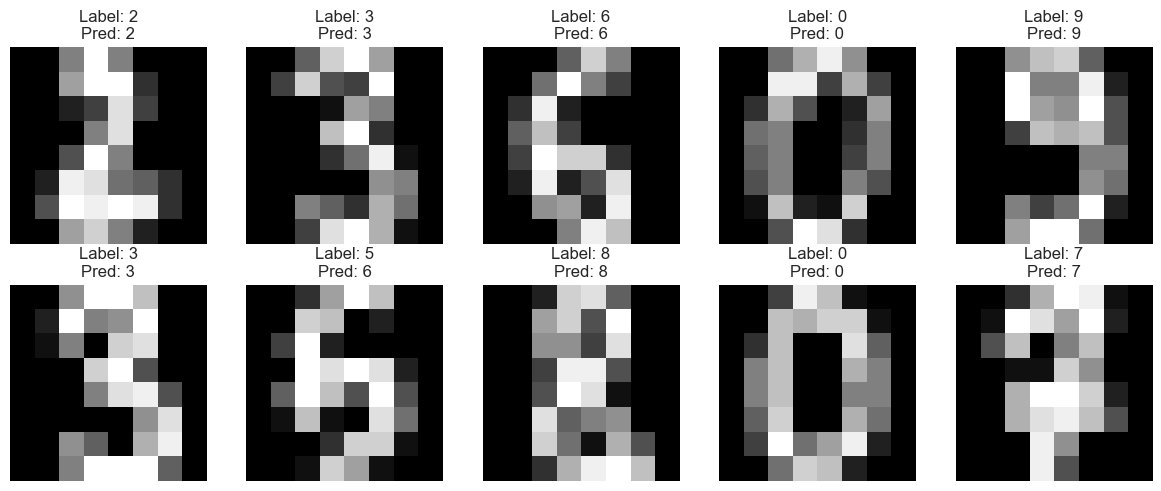

In [2]:
# Optical Digits Classification 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

# -------------------- 1. Load dataset --------------------
train_file = "optdigits.tra"
test_file = "optdigits.tes"

column_names = [f'pixel{i}' for i in range(64)] + ['label']
train_df = pd.read_csv(train_file, header=None, names=column_names)
test_df = pd.read_csv(test_file, header=None, names=column_names)

X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# -------------------- 2. Feature scaling --------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------- 3. LightGBM OvR Classifier --------------------
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=10,
    n_jobs=-1,
    random_state=42
)

classifier = OneVsRestClassifier(lgbm)

# -------------------- 4. Hyperparameter tuning --------------------
param_dist = {
    'estimator__n_estimators': [200, 400, 600, 800],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__num_leaves': [31, 50, 70, 90],
    'estimator__max_depth': [5, 8, 12, -1],
    'estimator__subsample': [0.6, 0.8, 1.0],
    'estimator__colsample_bytree': [0.6, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train_scaled, y_train)
best_model = search.best_estimator_
print("Best CV Accuracy:", search.best_score_)
print("Best Hyperparameters:", search.best_params_)

# -------------------- 5. Evaluate on Test Set --------------------
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# -------------------- 6. Visualizations --------------------
sns.set(style="whitegrid")

# 6.1 Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=y_train, palette="tab10")
plt.title("Class Distribution in Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

# 6.2 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 6.3 Feature Importance (Average across OvR models)
importances = np.mean([est.feature_importances_ for est in best_model.estimators_], axis=0)
plt.figure(figsize=(10,4))
sns.barplot(x=importances, y=X_train.columns, palette="magma")
plt.title("Average Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Pixel Features")
plt.tight_layout()
plt.show()

# 6.4 PCA 2D Projection
Xpca = PCA(n_components=2, random_state=42).fit_transform(X_test_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=Xpca[:,0], y=Xpca[:,1], hue=y_test, palette="tab10", s=50)
plt.title("PCA Projection of Test Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Digit", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# 6.5 Sample handwritten digits with prediction
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test))
    ax.imshow(X_test.iloc[idx].values.reshape(8,8), cmap='gray')
    ax.set_title(f"Label: {y_test.iloc[idx]}\nPred: {y_pred[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()
